## Concise

Concise extends keras (https://keras.io) by providing additional layers, intializers, regularizers, metrics and preprocessors, suited for modelling genomic cis-regulatory elements.

In [35]:
## Concise extensions of keras:

import concise
import concise.layers as cl
import concise.initializers as ci
import concise.regularizers as cr
import concise.metrics as cm
from concise.preprocessing import encodeDNA, encodeSplines

## layers:
cl.ConvDNA
cl.ConvDNAQuantitySplines
cr.GAMRegularizer
cl.GAMSmooth
cl.GlobalSumPooling1D
cl.InputDNA
cl.InputDNAQuantity
cl.InputDNAQuantitySplines

## initializers:
ci.PWMKernelInitializer
ci.PWMBiasInitializer

## regularizers
cr.GAMRegularizer

## metrics
cm.var_explained

## Preprocessing
encodeDNA
encodeSplines

<function concise.preprocessing.smooth.encodeSplines>

It also implements a PWM class, used by PWM*Initializers

In [36]:
from concise.utils import PWM

PWM

concise.utils.PWM

## Simulated data case study

In [37]:
## See dataset: 
#%matplotlib notebook
%matplotlib inline

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

## required keras modules
from keras.models import Model, load_model
import keras.layers as kl
import keras.optimizers as ko

In this notebook, we will replicate the results from [Plositional_effect/Simulation/01_fixed_seq_len.html](https://i12g-gagneurweb.in.tum.de/project/deepcis/#Scripts_Positional_effect_Simulation_01_fixed_seq_len.html) using concise models. Please have a look at that notebook first.




## Single motif case

### Prepare the data

In [5]:
# Load the data
data_dir = "../data/"
dt = pd.read_csv(data_dir + "/01-fixed_seq_len-1.csv")
motifs = ["TTAATGA"]

In [6]:
dt.head

<bound method NDFrame.head of             y                       seq
0      5.4763  TTCTGGGAGGCGTCCTTACGT...
1      0.2309  AAGTATGATCATACGCACCGT...
2      6.0881  TATGCAGGATCGAAATACTCT...
...       ...                       ...
2997   0.2773  GAGGGGTCAGCATGCGTATGA...
2998  15.6793  CTACCAAATCCAAACTTCAGC...
2999  13.0256  CTGACCATACGTTTCACACCG...

[3000 rows x 2 columns]>

In [7]:
seq_tensor = encodeDNA(dt["seq"])
y = dt.y.as_matrix()
## TODO - update back
seq_tensor = np.squeeze(seq_tensor, 1)

In [8]:
seq_tensor.shape # (n_samples, seq_length, n_bases)

(3000, 500, 4)

### Build the model

Concise is a thin wrapper around keras. To know more about keras, read the documentation: https://keras.io/.

In this tutorial, I'll be using the functional API of keras: https://keras.io/getting-started/functional-api-guide/. Feel free to use Concise with the sequential models.

In [9]:
## Parameters
seq_length = seq_tensor.shape[1]
## Motifs used to initialize the model
pwm_list = [PWM.from_consensus(motif) for motif in motifs]
motif_width = 7
pwm_list

[PWM(name: None, consensus: TTAATGA)]

In [10]:
np.random.seed(42)

# specify the input shape
input_dna = cl.InputDNA(seq_length)

# convolutional layer with filters initialized on a PWM
x = cl.ConvDNA(filters=1, 
               kernel_size=motif_width, ## motif width
               activation="relu", 
               kernel_initializer=ci.PWMKernelInitializer(pwm_list),
               bias_initializer=ci.PWMBiasInitializer(pwm_list,kernel_size=motif_width, mean_max_scale=1)
               ## mean_max_scale of 1 means that only consensus sequence gets score larger than 0
              )(input_dna)

## Smoothing layer - positional-dependent effect
x = cl.GAMSmooth(n_bases=10, l2_smooth=1e-3, l2=0)(x)
x = cl.GlobalSumPooling1D()(x)
x = kl.Dense(units=1,activation="linear")(x)
model = Model(inputs=input_dna, outputs=x)

# compile the model
model.compile(optimizer="adam", loss="mse", metrics=[cm.var_explained])

### Train the model

In [11]:
## TODO - create a callback
from keras.callbacks import EarlyStopping

model.fit(x=seq_tensor, y=y, epochs=30, verbose=2,
          callbacks=[EarlyStopping(patience=5)],
          validation_split=.2
         )

Train on 2400 samples, validate on 600 samples
Epoch 1/30
0s - loss: 13.4338 - var_explained: 0.0810 - val_loss: 12.7532 - val_var_explained: 0.1765
Epoch 2/30
0s - loss: 9.4247 - var_explained: 0.3185 - val_loss: 7.6765 - val_var_explained: 0.4527
Epoch 3/30
0s - loss: 4.9749 - var_explained: 0.5713 - val_loss: 4.4231 - val_var_explained: 0.6337
Epoch 4/30
0s - loss: 3.6143 - var_explained: 0.6624 - val_loss: 3.8643 - val_var_explained: 0.6773
Epoch 5/30
0s - loss: 3.3813 - var_explained: 0.6763 - val_loss: 3.6636 - val_var_explained: 0.6943
Epoch 6/30
0s - loss: 3.2000 - var_explained: 0.6990 - val_loss: 3.4836 - val_var_explained: 0.7090
Epoch 7/30
0s - loss: 3.0308 - var_explained: 0.7137 - val_loss: 3.3011 - val_var_explained: 0.7242
Epoch 8/30
0s - loss: 2.8638 - var_explained: 0.7348 - val_loss: 3.1217 - val_var_explained: 0.7391
Epoch 9/30
0s - loss: 2.7092 - var_explained: 0.7468 - val_loss: 2.9468 - val_var_explained: 0.7537
Epoch 10/30
0s - loss: 2.5648 - var_explained: 0.76

### Save and load the model

With keras, we can save and load the entire model to the hdf5 file.

In [12]:
model.save("/tmp/model.h5") ## requires h5py pacakge, pip install h5py

In [13]:
%ls -la  /tmp/model*

-rw-rw-r--. 1 avsec ag_gagneur 23968 Mar 24 19:46 /tmp/model.h5


In [14]:
model2 = load_model("/tmp/model.h5")
model2

### Interpret the model

#### Predictions

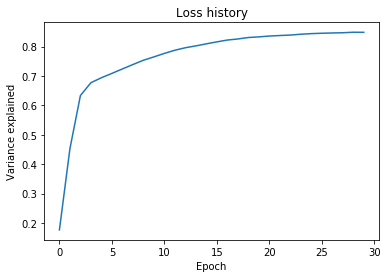

In [15]:
var_expl_history = model.history.history['val_var_explained']
plt.plot(var_expl_history)
plt.ylabel('Variance explained')
plt.xlabel('Epoch')
plt.title("Loss history")

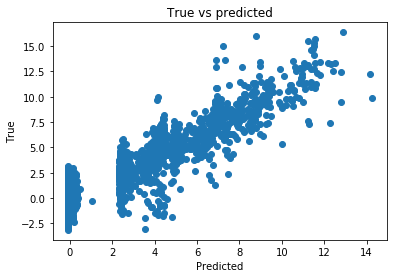

In [16]:
y_pred = model.predict(seq_tensor)
plt.scatter(y_pred, y)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("True vs predicted")

Plot is the same as in the [original motifp report](https://i12g-gagneurweb.in.tum.de/project/deepcis/#Scripts_Positional_effect_Simulation_01_fixed_seq_len.html).

#### Weights

In [17]:
# layers in the model
model.layers

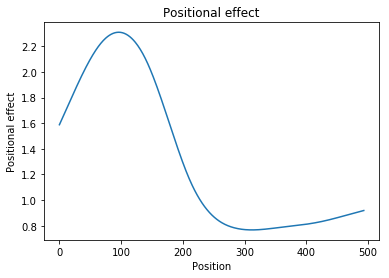

In [18]:
## Convenience functions in layers
gam_layer = model.layers[2]
gam_layer.plot()
plt.title("Positional effect")

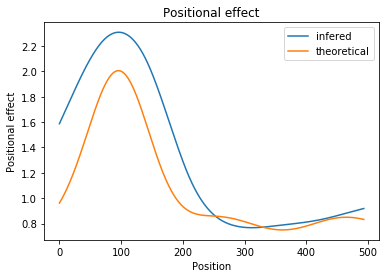

In [19]:
# Compare the curve to the theoretical
positions = gam_layer.positional_effect()["positions"]
pos_effect = gam_layer.positional_effect()["positional_effect"]

from scipy.stats import norm
pef = lambda x: 0.3*norm.pdf(x, 0.2, 0.1) + 0.05*np.sin(15*x) + 0.8
pos_effect_theoretical = pef(positions / positions.max())

# plot
plt.plot(positions, pos_effect, label="infered")
plt.plot(positions, pos_effect_theoretical, label="theoretical")
plt.ylabel('Positional effect')
plt.xlabel('Position')
plt.title("Positional effect")
plt.legend()

Qualitatively, the curves are the same, quantitatively, they differ as the scale is modulated by other parameters in the model. Plot is similar to the [original motifp report](https://i12g-gagneurweb.in.tum.de/project/deepcis/#Scripts_Positional_effect_Simulation_01_fixed_seq_len.html).

## Model with two motifs

In [20]:
dt = pd.read_csv(data_dir + "/01-fixed_seq_len-2.csv")
motifs = ["TTAATGA", "TATTTAT"]

In [21]:
## Parameters
seq_length = seq_tensor.shape[1]
## Motifs used to initialize the model
pwm_list = [PWM.from_consensus(motif) for motif in motifs]
motif_width = 7
pwm_list

[PWM(name: None, consensus: TTAATGA), PWM(name: None, consensus: TATTTAT)]

In [22]:
np.random.seed(1)
input_dna = cl.InputDNA(seq_length)
# convolutional layer with filters initialized on a PWM
x = cl.ConvDNA(filters=2, 
               kernel_size=motif_width, ## motif width
               activation="relu", 
               kernel_initializer=ci.PWMKernelInitializer(pwm_list, stddev=0.0),
               bias_initializer=ci.PWMBiasInitializer(pwm_list,kernel_size=motif_width, mean_max_scale=0.999),
               ## mean_max_scale of 1 means that only consensus sequence gets score larger than 0
               trainable=False,
              )(input_dna)
## Smoothing layer - positional-dependent effect
x = cl.GAMSmooth(n_bases=10, l2_smooth=1e-6, l2=0)(x)
x = cl.GlobalSumPooling1D()(x)
x = kl.Dense(units=1,activation="linear")(x)
model = Model(inputs=input_dna, outputs=x)

# compile the model
model.compile(optimizer=ko.Adam(lr=0.01), loss="mse", metrics=[cm.var_explained])

In [23]:
seq_tensor = encodeDNA(dt["seq"])
y = dt.y.as_matrix()
## TODO - update back
seq_tensor = np.squeeze(seq_tensor, 1)

In [24]:
model.fit(x=seq_tensor, y=y, epochs=100, verbose = 2,
          callbacks=[EarlyStopping(patience=5)],
          validation_split=.2
         )

Train on 2400 samples, validate on 600 samples
Epoch 1/100
0s - loss: 10.5280 - var_explained: 0.0046 - val_loss: 8.8872 - val_var_explained: 0.0083
Epoch 2/100
0s - loss: 8.7351 - var_explained: 0.0136 - val_loss: 7.6761 - val_var_explained: 0.0197
Epoch 3/100
0s - loss: 7.8710 - var_explained: 0.0272 - val_loss: 7.1232 - val_var_explained: 0.0358
Epoch 4/100
0s - loss: 7.4637 - var_explained: 0.0454 - val_loss: 6.8615 - val_var_explained: 0.0558
Epoch 5/100
0s - loss: 7.2226 - var_explained: 0.0669 - val_loss: 6.6635 - val_var_explained: 0.0795
Epoch 6/100
0s - loss: 7.0131 - var_explained: 0.0926 - val_loss: 6.4575 - val_var_explained: 0.1074
Epoch 7/100
0s - loss: 6.7888 - var_explained: 0.1207 - val_loss: 6.2361 - val_var_explained: 0.1376
Epoch 8/100
0s - loss: 6.5453 - var_explained: 0.1549 - val_loss: 5.9893 - val_var_explained: 0.1707
Epoch 9/100
0s - loss: 6.2794 - var_explained: 0.1873 - val_loss: 5.7242 - val_var_explained: 0.2061
Epoch 10/100
0s - loss: 5.9950 - var_explai

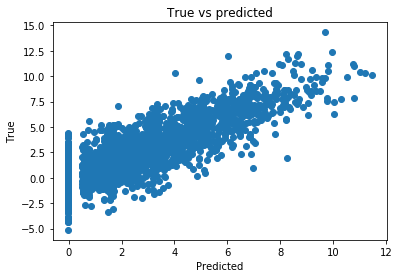

In [25]:
y_pred = model.predict(seq_tensor)
plt.scatter(y_pred, y)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("True vs predicted")

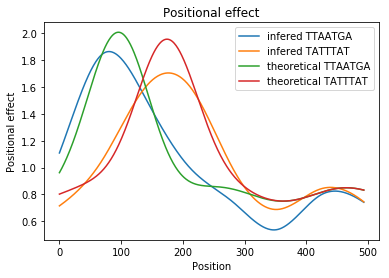

In [26]:
## TODO - update to the new synthax
gam_layer = model.layers[2]

positions = gam_layer.positional_effect()["positions"]
pos_effect = gam_layer.positional_effect()["positional_effect"]

## Theoretical plot - from the original simulation data
from scipy.stats import norm
# https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.stats.norm.html#scipy.stats.norm
pef1 = lambda x: 0.3*norm.pdf(x, 0.2, 0.1) + 0.05*np.sin(15*x) + 0.8
pos_effect_theoretical1 = pef1(positions / positions.max())
pef2 = lambda x: 0.3*norm.pdf(x, 0.35, 0.1) + 0.05*np.sin(15*x) + 0.8
pos_effect_theoretical2 = pef2(positions / positions.max())


w_motifs = model.get_weights()[-2]
b = model.get_weights()[-1]

## Create a new plot
pos_effect_calibrated = (pos_effect / np.transpose(w_motifs))/ 0.8
plt.plot(positions, pos_effect_calibrated[:,0], label="infered " + motifs[0])
plt.plot(positions, pos_effect_calibrated[:,1], label="infered " + motifs[1])
plt.plot(positions, pos_effect_theoretical1, label="theoretical " + motifs[0])
plt.plot(positions, pos_effect_theoretical2, label="theoretical " + motifs[1])
plt.ylabel('Positional effect')
plt.xlabel('Position')
plt.title("Positional effect")
plt.legend()